In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [10]:
class AudioDWTTransformer:
    def __init__(self, wavelet='db4', level=4):
        self.wavelet = wavelet
        self.level = level
        self.coeffs = None
        self.audio_data = None
        self.sample_rate = None
        self.original_length = 0
        
    def load_audio(self, file_path, duration=None, sr=22050):
        """Load audio file with optional duration limit and resampling"""
        try:
            if duration:
                self.audio_data, self.sample_rate = librosa.load(
                    file_path, sr=sr, duration=duration, mono=True
                )
            else:
                self.audio_data, self.sample_rate = librosa.load(
                    file_path, sr=sr, mono=True
                )
            
            self.original_length = len(self.audio_data)
            print(f"Loaded audio: {len(self.audio_data)} samples, {self.sample_rate} Hz")
            return self.audio_data, self.sample_rate
            
        except Exception as e:
            print(f"Error loading audio: {e}")
            return None, None
    
    def get_max_decomposition_level(self, signal_length):
        """Calculate maximum possible decomposition level for given signal length"""
        return pywt.dwt_max_level(signal_length, self.wavelet)
    
    def apply_dwt(self, audio_data=None):
        """Apply DWT to audio signal with proper length handling"""
        if audio_data is None:
            audio_data = self.audio_data
            
        if audio_data is None:
            raise ValueError("No audio data provided. Please load audio first.")
        
        # Calculate maximum possible level
        max_level = self.get_max_decomposition_level(len(audio_data))
        if self.level > max_level:
            print(f"Warning: Requested level {self.level} is too high. Using maximum level {max_level}")
            self.level = max_level
        elif self.level <= 0:
            self.level = max_level
            
        print(f"Applying DWT with level {self.level} using {self.wavelet} wavelet")
        
        try:
            # Apply multi-level DWT
            self.coeffs = pywt.wavedec(audio_data, self.wavelet, level=self.level)
            print(f"DWT successful. Coefficients: {len(self.coeffs)} levels")
            return self.coeffs
        except Exception as e:
            print(f"Error in DWT: {e}")
            # Try with reduced level
            if self.level > 1:
                self.level -= 1
                print(f"Retrying with level {self.level}")
                return self.apply_dwt(audio_data)
            else:
                raise e
    
    def apply_idwt(self, coeffs=None):
        """Apply inverse DWT to reconstruct audio with length matching"""
        if coeffs is None:
            coeffs = self.coeffs
            
        if coeffs is None:
            raise ValueError("No coefficients available. Please apply DWT first.")
            
        try:
            reconstructed_audio = pywt.waverec(coeffs, self.wavelet)
            
            # Trim to original length to avoid length mismatches
            if hasattr(self, 'original_length') and self.original_length > 0:
                reconstructed_audio = reconstructed_audio[:self.original_length]
                
            print(f"IDWT successful. Reconstructed length: {len(reconstructed_audio)}")
            return reconstructed_audio
        except Exception as e:
            print(f"Error in IDWT: {e}")
            return np.array([])
    
    def denoise_audio(self, threshold_factor=0.1, mode='soft'):
        """Apply thresholding for denoising with different modes"""
        if self.coeffs is None:
            self.apply_dwt()
            
        denoised_coeffs = []
        for coeff in self.coeffs:
            denoised_coeffs.append(coeff.copy())
        
        # Apply thresholding to detail coefficients (skip approximation coefficient)
        for i in range(1, len(denoised_coeffs)):
            if len(denoised_coeffs[i]) > 0:
                threshold = threshold_factor * np.median(np.abs(denoised_coeffs[i])) / 0.6745
                denoised_coeffs[i] = pywt.threshold(denoised_coeffs[i], threshold, mode=mode)
        
        denoised_audio = self.apply_idwt(denoised_coeffs)
        if len(denoised_audio) > 0:
            print(f"Denoising applied with {mode} thresholding (factor: {threshold_factor})")
        return denoised_audio, denoised_coeffs
    
    def compress_audio(self, compression_ratio=0.5, mode='hard'):
        """Apply compression with different thresholding modes"""
        if self.coeffs is None:
            self.apply_dwt()
            
        compressed_coeffs = []
        for coeff in self.coeffs:
            compressed_coeffs.append(coeff.copy())
        
        # Calculate threshold based on compression ratio
        all_coeffs = np.concatenate([c.flatten() for c in compressed_coeffs if len(c) > 0])
        if len(all_coeffs) == 0:
            print("Warning: No coefficients to compress")
            return self.audio_data, compressed_coeffs
            
        threshold = np.percentile(np.abs(all_coeffs), (1 - compression_ratio) * 100)
        
        # Count coefficients before and after compression
        original_nonzero = np.sum([np.count_nonzero(c) for c in compressed_coeffs])
        
        # Apply thresholding to all coefficients
        for i in range(len(compressed_coeffs)):
            if len(compressed_coeffs[i]) > 0:
                compressed_coeffs[i] = pywt.threshold(compressed_coeffs[i], threshold, mode=mode)
        
        compressed_nonzero = np.sum([np.count_nonzero(c) for c in compressed_coeffs])
        compression_percent = (1 - compressed_nonzero / original_nonzero) * 100 if original_nonzero > 0 else 0
        
        compressed_audio = self.apply_idwt(compressed_coeffs)
        if len(compressed_audio) > 0:
            print(f"Compression applied: {compression_percent:.1f}% coefficients zeroed")
        return compressed_audio, compressed_coeffs
    
    def analyze_coefficients_energy(self, coeffs=None):
        """Analyze energy distribution across wavelet coefficients"""
        if coeffs is None:
            coeffs = self.coeffs
            
        energy_distribution = []
        total_energy = 0
        
        for i, coeff in enumerate(coeffs):
            if len(coeff) > 0:
                energy = np.sum(coeff**2)
                energy_distribution.append(energy)
                total_energy += energy
            else:
                energy_distribution.append(0)
        
        # Normalize and calculate percentages
        energy_percentages = [(energy / total_energy) * 100 for energy in energy_distribution] if total_energy > 0 else [0] * len(energy_distribution)
        
        return energy_distribution, energy_percentages
    
    def plot_original_vs_reconstructed(self, original_audio, reconstructed_audio, title="Original vs Reconstructed"):
        """Enhanced comparison plot with energy analysis"""
        if len(reconstructed_audio) == 0:
            print("Error: Reconstructed audio is empty. Cannot create plot.")
            return 0, 0, 0
        
        # Ensure same length
        min_len = min(len(original_audio), len(reconstructed_audio))
        if min_len == 0:
            print("Error: One of the audio signals is empty.")
            return 0, 0, 0
            
        original_audio_trimmed = original_audio[:min_len]
        reconstructed_audio_trimmed = reconstructed_audio[:min_len]
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time domain comparison
        time_axis = np.arange(min_len) / self.sample_rate
        ax1.plot(time_axis, original_audio_trimmed, 'b-', alpha=0.7, label='Original', linewidth=1)
        ax1.plot(time_axis, reconstructed_audio_trimmed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
        ax1.set_title(f'{title} - Time Domain')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Frequency domain comparison
        try:
            f_orig, Pxx_orig = signal.welch(original_audio_trimmed, self.sample_rate, nperseg=1024)
            f_recon, Pxx_recon = signal.welch(reconstructed_audio_trimmed, self.sample_rate, nperseg=1024)
            
            ax2.semilogy(f_orig, Pxx_orig, 'b-', alpha=0.7, label='Original')
            ax2.semilogy(f_recon, Pxx_recon, 'r-', alpha=0.7, label='Reconstructed')
            ax2.set_title(f'{title} - Frequency Domain')
            ax2.set_xlabel('Frequency (Hz)')
            ax2.set_ylabel('Power Spectral Density')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        except Exception as e:
            ax2.text(0.5, 0.5, f'Error in PSD: {e}', transform=ax2.transAxes, ha='center')
            ax2.set_title('Frequency Domain - Error')
        
        # Error plot
        error = original_audio_trimmed - reconstructed_audio_trimmed
        ax3.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
        ax3.set_title('Reconstruction Error')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Error')
        ax3.grid(True, alpha=0.3)
        
        # Energy distribution
        if self.coeffs is not None:
            energy_dist, energy_percent = self.analyze_coefficients_energy()
            levels = [f'L{self.level}'] + [f'D{self.level-i+1}' for i in range(1, len(self.coeffs))]
            colors = plt.cm.viridis(np.linspace(0, 1, len(levels)))
            bars = ax4.bar(levels, energy_percent, color=colors, alpha=0.7)
            ax4.set_title('Energy Distribution by Level')
            ax4.set_ylabel('Energy Percentage (%)')
            ax4.tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for bar, percentage in zip(bars, energy_percent):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate metrics
        mse = np.mean(error**2)
        snr = 10 * np.log10(np.var(original_audio_trimmed) / (mse + 1e-10))
        max_error = np.max(np.abs(error))
        
        print(f"Mean Squared Error: {mse:.6f}")
        print(f"Signal-to-Noise Ratio: {snr:.2f} dB")
        print(f"Maximum Error: {max_error:.6f}")
        
        return mse, snr, max_error
    
    def plot_wavelet_coefficients(self, coeffs=None, title="Wavelet Coefficients"):
        """Enhanced wavelet coefficients visualization"""
        if coeffs is None:
            coeffs = self.coeffs
            
        if coeffs is None or any(len(c) == 0 for c in coeffs):
            print("Error: No valid coefficients to plot")
            return
            
        fig, axes = plt.subplots(len(coeffs), 1, figsize=(14, 3*len(coeffs)))
        
        if len(coeffs) == 1:
            axes = [axes]
            
        for i, (coeff, ax) in enumerate(zip(coeffs, axes)):
            if len(coeff) == 0:
                ax.text(0.5, 0.5, 'No coefficients', transform=ax.transAxes, ha='center')
                continue
                
            if i == 0:
                label = f'Approximation (Level {self.level})'
                color = 'red'
            else:
                label = f'Detail (Level {self.level - i + 1})'
                color = 'blue'
                
            ax.plot(coeff, color=color, linewidth=0.8)
            ax.set_title(f'{label} - {len(coeff)} coefficients')
            ax.set_ylabel('Amplitude')
            ax.grid(True, alpha=0.3)
            
            # Add statistics
            stats_text = f'Mean: {np.mean(coeff):.4f}\nStd: {np.std(coeff):.4f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
        axes[-1].set_xlabel('Coefficient Index')
        plt.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_spectrograms(self, original_audio, transformed_audio, title_comparison):
        """Enhanced spectrogram comparison"""
        if len(transformed_audio) == 0:
            print("Error: Transformed audio is empty. Cannot create spectrogram.")
            return
            
        # Ensure same length
        min_len = min(len(original_audio), len(transformed_audio))
        if min_len == 0:
            print("Error: One of the audio signals is empty.")
            return
            
        original_audio_trimmed = original_audio[:min_len]
        transformed_audio_trimmed = transformed_audio[:min_len]
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
        
        try:
            # Original spectrogram
            S_orig = librosa.stft(original_audio_trimmed, n_fft=1024, hop_length=256)
            S_db_orig = librosa.amplitude_to_db(np.abs(S_orig), ref=np.max)
            img1 = librosa.display.specshow(S_db_orig, sr=self.sample_rate, 
                                          x_axis='time', y_axis='log', ax=ax1)
            ax1.set_title('Original Audio - Spectrogram', fontweight='bold')
            plt.colorbar(img1, ax=ax1, format='%+2.0f dB')
            
            # Transformed spectrogram
            S_trans = librosa.stft(transformed_audio_trimmed, n_fft=1024, hop_length=256)
            S_db_trans = librosa.amplitude_to_db(np.abs(S_trans), ref=np.max)
            img2 = librosa.display.specshow(S_db_trans, sr=self.sample_rate, 
                                          x_axis='time', y_axis='log', ax=ax2)
            ax2.set_title(f'{title_comparison} - Spectrogram', fontweight='bold')
            plt.colorbar(img2, ax=ax2, format='%+2.0f dB')
            
            # Difference spectrogram
            S_diff = S_db_orig - S_db_trans
            img3 = librosa.display.specshow(S_diff, sr=self.sample_rate, 
                                          x_axis='time', y_axis='log', ax=ax3, cmap='coolwarm')
            ax3.set_title('Difference Spectrogram', fontweight='bold')
            plt.colorbar(img3, ax=ax3, format='%+2.0f dB')
            
        except Exception as e:
            for ax in [ax1, ax2, ax3]:
                ax.text(0.5, 0.5, f'Spectrogram Error: {e}', transform=ax.transAxes, ha='center')
            
        plt.tight_layout()
        plt.show()
    
    def save_audio(self, audio_data, filename, sample_rate=None):
        """Save audio to WAV file with proper normalization"""
        if sample_rate is None:
            sample_rate = self.sample_rate
            
        if len(audio_data) == 0:
            print(f"Warning: Cannot save empty audio data for {filename}")
            return
            
        # Create output directory if it doesn't exist
        os.makedirs('output', exist_ok=True)
        filepath = Path('output') / filename
        
        # Normalize audio to prevent clipping while preserving dynamics
        max_val = np.max(np.abs(audio_data))
        if max_val > 0:
            audio_normalized = np.int16(audio_data / max_val * 32767)
        else:
            audio_normalized = np.int16(audio_data)
            
        wavfile.write(filepath, sample_rate, audio_normalized)
        print(f"Audio saved as {filepath}")

Found audio file: UrbanSound8K/any_wav.wav
Loading audio file: UrbanSound8K/any_wav.wav
Loaded audio: 49613 samples, 22050 Hz
Audio length: 49613 samples
Sample rate: 22050 Hz
Duration: 2.25 seconds
Maximum decomposition level: 12

1. Applying DWT and reconstruction...
Applying DWT with level 4 using db4 wavelet
DWT successful. Coefficients: 5 levels
IDWT successful. Reconstructed length: 49613


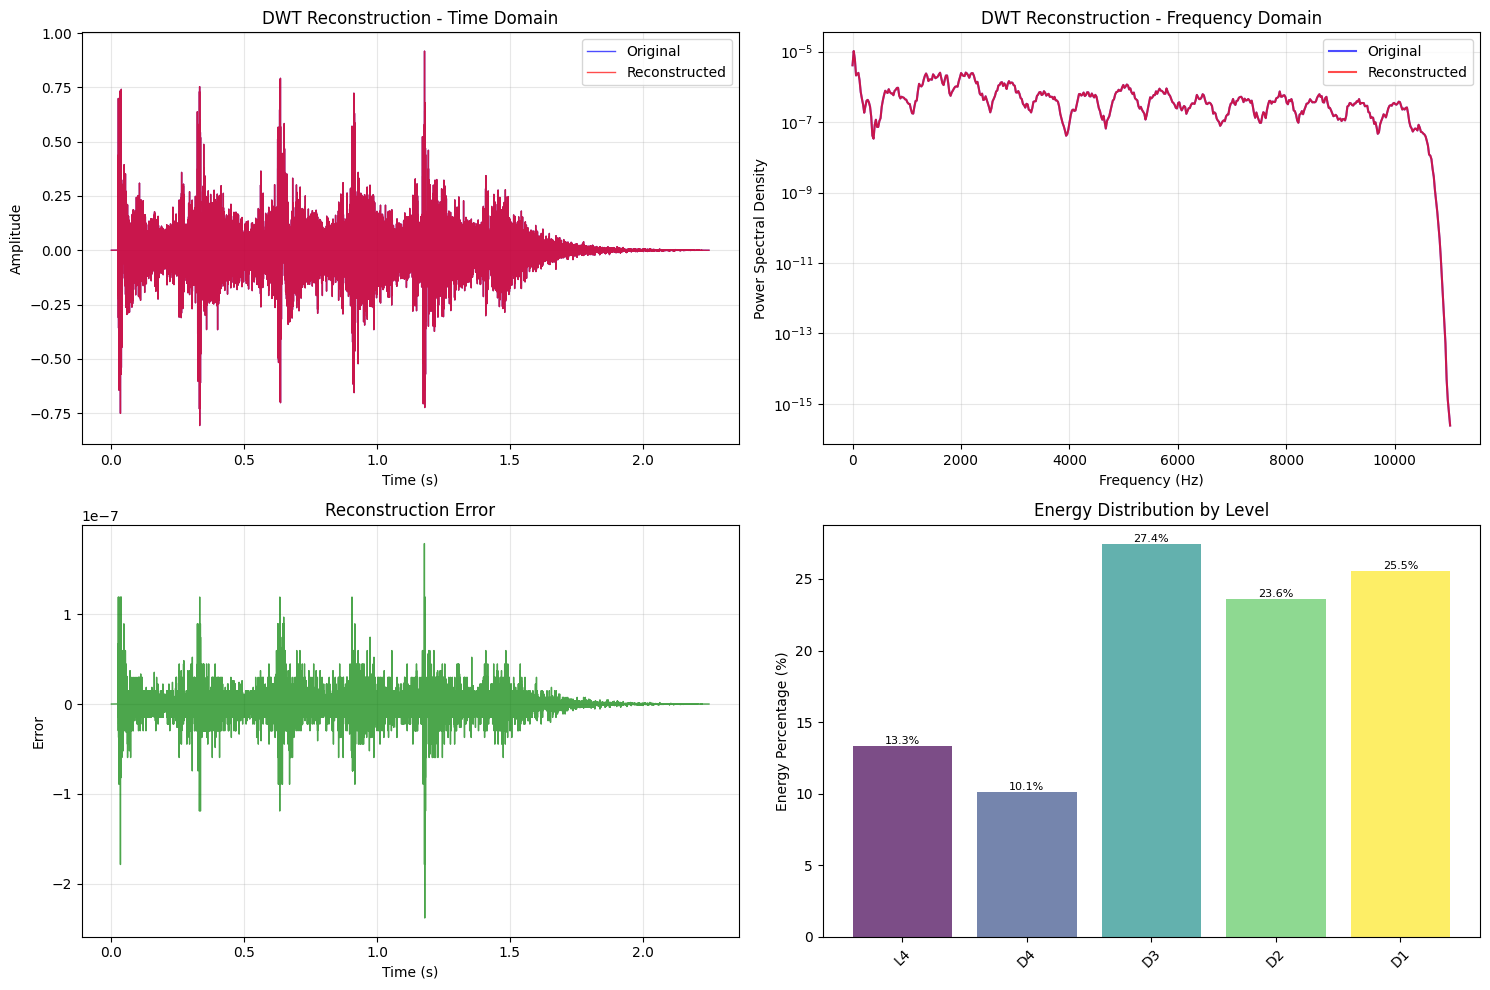

Mean Squared Error: 0.000000
Signal-to-Noise Ratio: 77.91 dB
Maximum Error: 0.000000


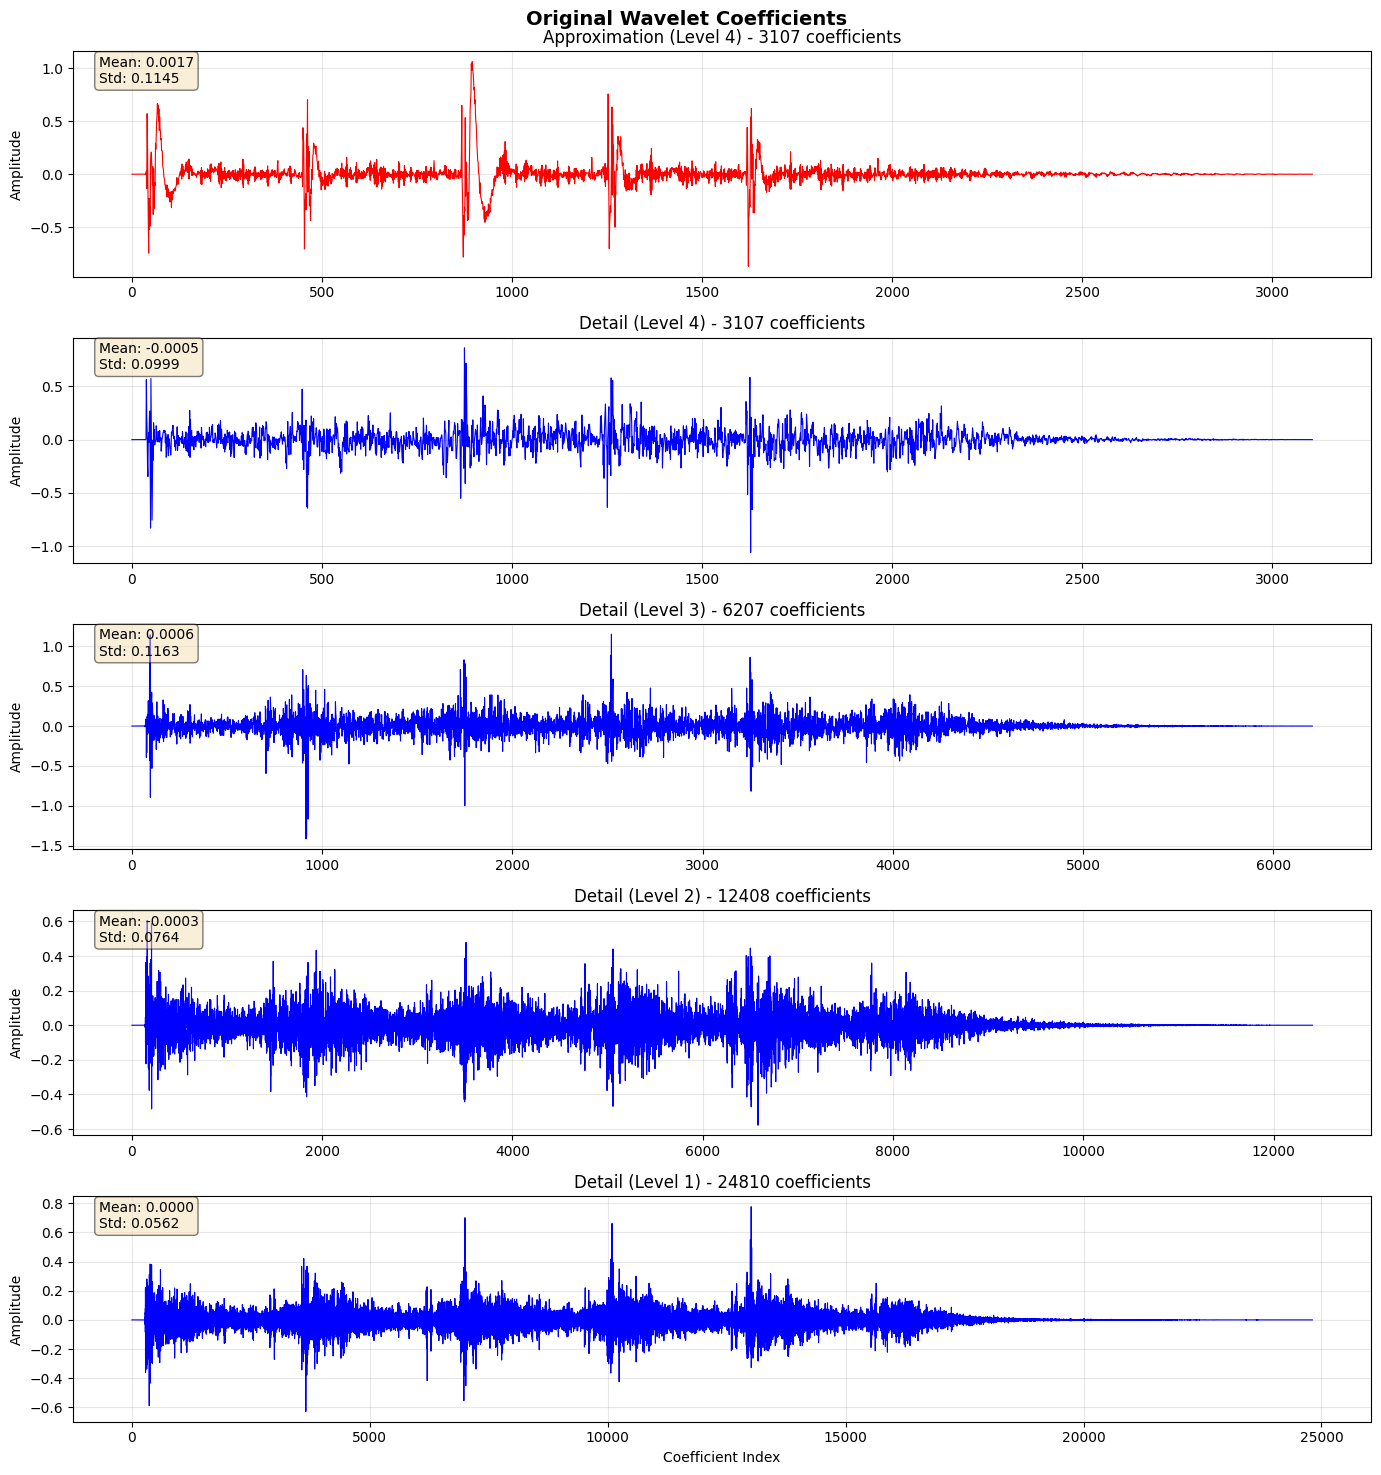


2. Applying denoising...
IDWT successful. Reconstructed length: 49613
Denoising applied with soft thresholding (factor: 0.1)


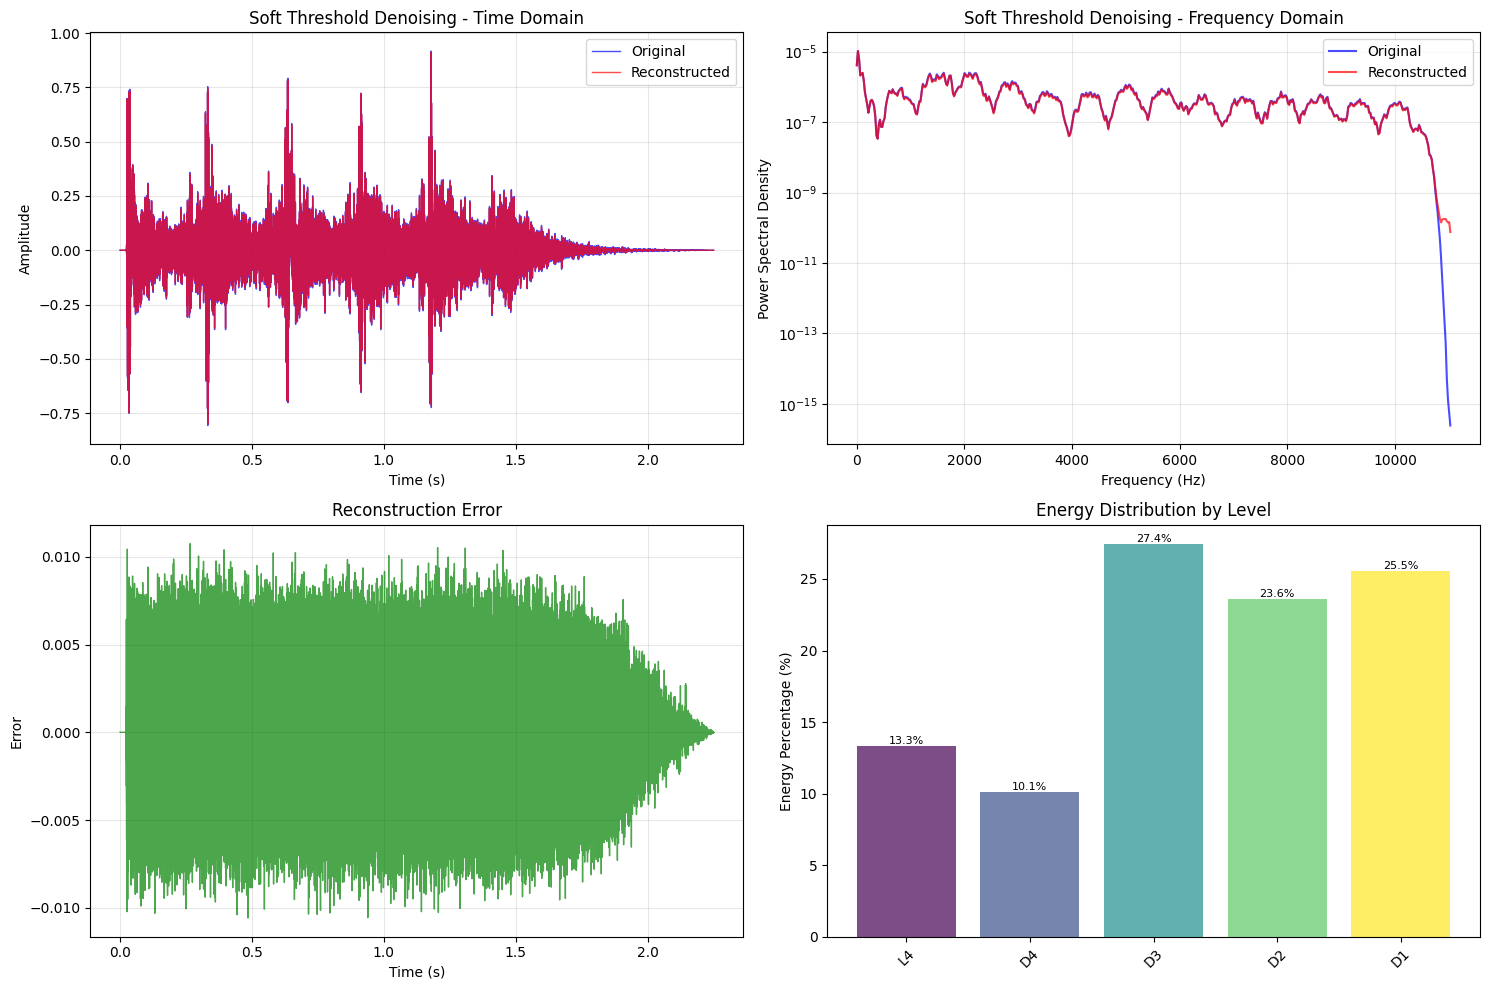

Mean Squared Error: 0.000011
Signal-to-Noise Ratio: 27.55 dB
Maximum Error: 0.010754
IDWT successful. Reconstructed length: 49613
Denoising applied with hard thresholding (factor: 0.15)


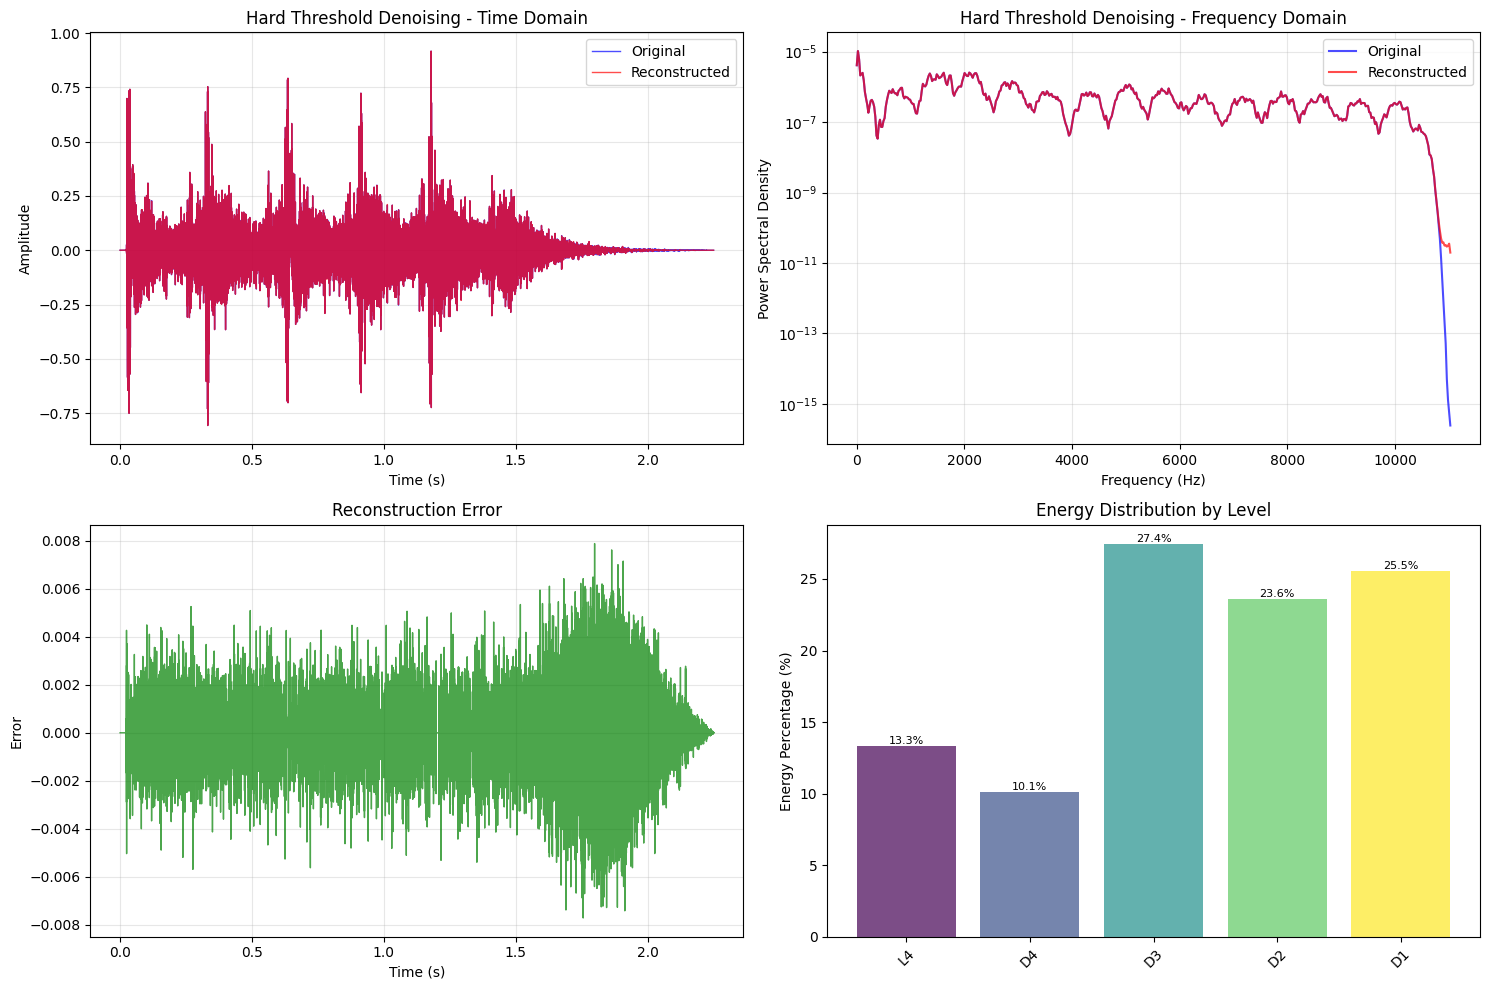

Mean Squared Error: 0.000001
Signal-to-Noise Ratio: 36.72 dB
Maximum Error: 0.007887

3. Comparing different wavelets...
Applying DWT with level 3 using db4 wavelet
DWT successful. Coefficients: 4 levels
IDWT successful. Reconstructed length: 49614
Applying DWT with level 3 using db8 wavelet
DWT successful. Coefficients: 4 levels
IDWT successful. Reconstructed length: 49614
Applying DWT with level 3 using sym4 wavelet
DWT successful. Coefficients: 4 levels
IDWT successful. Reconstructed length: 49614
Applying DWT with level 3 using haar wavelet
DWT successful. Coefficients: 4 levels
IDWT successful. Reconstructed length: 49614


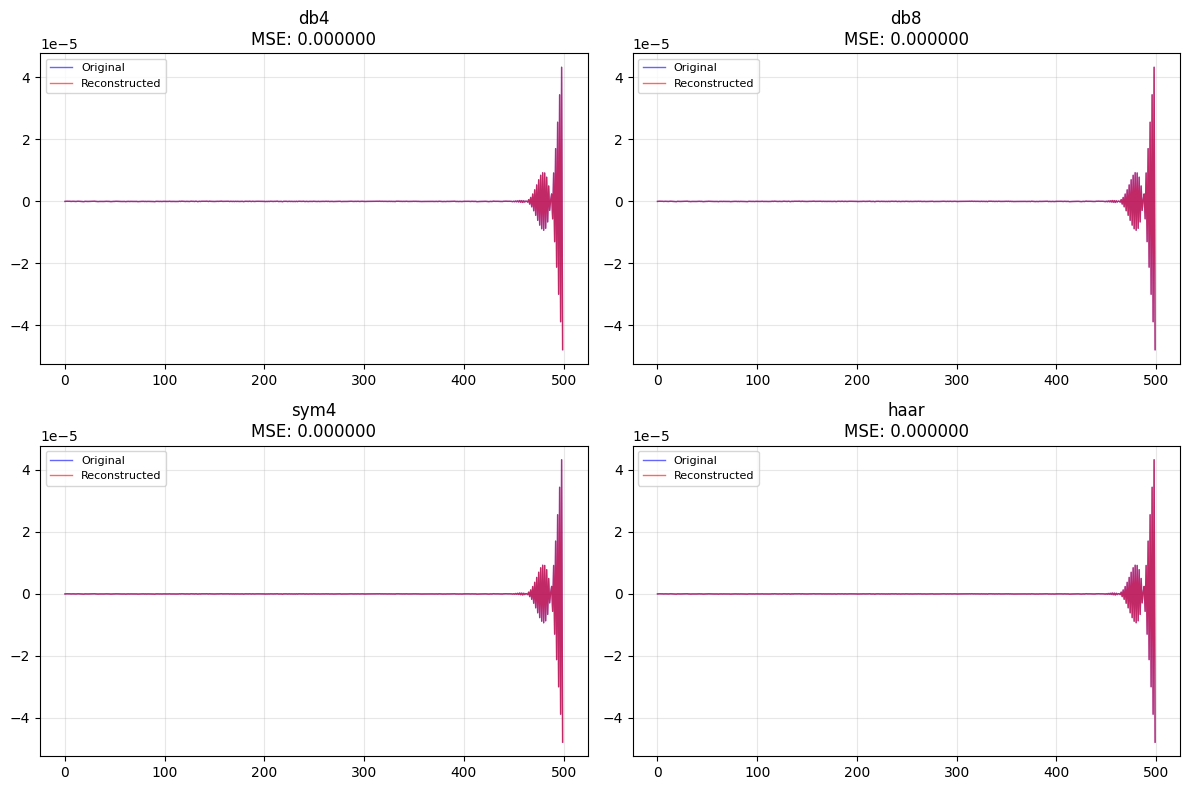


MSE Comparison for Different Wavelets:
  haar: 0.000000
  db4: 0.000000
  sym4: 0.000000
  db8: 0.000000

4. Saving processed audio files...
Audio saved as output\original_audio.wav
Audio saved as output\reconstructed_audio.wav
IDWT successful. Reconstructed length: 49613
Denoising applied with soft thresholding (factor: 0.1)
Audio saved as output\denoised_audio.wav

DWT Audio Processing Complete!
Check the 'output' folder for saved audio files.


In [11]:
def demonstrate_dwt_audio_processing(audio_file_path=None):
    """Enhanced demonstration with robust error handling"""
    
    # Initialize DWT transformer with safer default level
    transformer = AudioDWTTransformer(wavelet='db4', level=4)  # Reduced default level
    
    if audio_file_path and os.path.exists(audio_file_path):
        print(f"Loading audio file: {audio_file_path}")
        # Load shorter duration for stability
        audio_data, sample_rate = transformer.load_audio(audio_file_path, duration=3)
    else:
        print("No valid audio file provided. Creating sample audio...")
        # Create sample audio
        sample_rate = 22050
        duration = 3
        t = np.linspace(0, duration, int(sample_rate * duration))
        
        # More complex signal with chirp and harmonics
        signal_clean = (0.4 * np.sin(2 * np.pi * 220 * t) +  # A3 note
                        0.3 * np.sin(2 * np.pi * 440 * t) +  # A4 note
                        0.2 * np.sin(2 * np.pi * 880 * t) +  # A5 note
                        0.1 * np.sin(2 * np.pi * 1320 * t))  # E6 note
        
        # Add colored noise
        noise = 0.08 * np.random.normal(0, 1, len(t))
        audio_data = signal_clean + noise
        transformer.audio_data = audio_data
        transformer.sample_rate = sample_rate
    
    if audio_data is None or len(audio_data) == 0:
        print("Error: No audio data available. Exiting.")
        return None
        
    print(f"Audio length: {len(audio_data)} samples")
    print(f"Sample rate: {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Calculate and display maximum decomposition level
    max_level = transformer.get_max_decomposition_level(len(audio_data))
    print(f"Maximum decomposition level: {max_level}")
    
    # Adjust level if necessary
    if transformer.level > max_level:
        transformer.level = max_level
        print(f"Adjusted decomposition level to: {transformer.level}")
    
    # 1. Basic DWT and reconstruction
    print("\n" + "="*50)
    print("1. Applying DWT and reconstruction...")
    try:
        coeffs = transformer.apply_dwt()
        reconstructed_audio = transformer.apply_idwt()
        
        if len(reconstructed_audio) > 0:
            transformer.plot_original_vs_reconstructed(audio_data, reconstructed_audio, 
                                                      "DWT Reconstruction")
            transformer.plot_wavelet_coefficients(coeffs, "Original Wavelet Coefficients")
        else:
            print("Error: Reconstruction failed. Skipping plots.")
            
    except Exception as e:
        print(f"Error in DWT/reconstruction: {e}")
        # Try to continue with other demonstrations
        reconstructed_audio = np.array([])
    
    # 2. Denoising with different methods (only if reconstruction worked)
    print("\n" + "="*50)
    print("2. Applying denoising...")
    
    if len(reconstructed_audio) > 0:
        try:
            # Soft thresholding
            denoised_soft, denoised_coeffs_soft = transformer.denoise_audio(
                threshold_factor=0.1, mode='soft'
            )
            if len(denoised_soft) > 0:
                transformer.plot_original_vs_reconstructed(
                    audio_data, denoised_soft, "Soft Threshold Denoising"
                )
            
            # Hard thresholding
            denoised_hard, denoised_coeffs_hard = transformer.denoise_audio(
                threshold_factor=0.15, mode='hard'
            )
            if len(denoised_hard) > 0:
                transformer.plot_original_vs_reconstructed(
                    audio_data, denoised_hard, "Hard Threshold Denoising"
                )
        except Exception as e:
            print(f"Error in denoising: {e}")
    else:
        print("Skipping denoising due to previous reconstruction failure")
    
    # 3. Compare different wavelets (simplified)
    print("\n" + "="*50)
    print("3. Comparing different wavelets...")
    
    wavelets = ['db4', 'db8', 'sym4', 'haar']  # Simpler wavelets
    mse_results = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    successful_wavelets = 0
    for i, wavelet in enumerate(wavelets):
        if i >= len(axes):
            break
            
        try:
            transformer_temp = AudioDWTTransformer(wavelet=wavelet, level=3)  # Reduced level
            coeffs_temp = transformer_temp.apply_dwt(audio_data)
            reconstructed_temp = transformer_temp.apply_idwt(coeffs_temp)
            
            if len(reconstructed_temp) > 0 and len(audio_data) > 0:
                min_len = min(len(audio_data), len(reconstructed_temp))
                error = np.mean((audio_data[:min_len] - reconstructed_temp[:min_len])**2)
                mse_results[wavelet] = error
                
                # Plot first 500 samples for clarity
                plot_len = min(500, min_len)
                axes[i].plot(audio_data[:plot_len], 'b-', alpha=0.6, label='Original', linewidth=1)
                axes[i].plot(reconstructed_temp[:plot_len], 'r-', alpha=0.6, label='Reconstructed', linewidth=1)
                axes[i].set_title(f'{wavelet}\nMSE: {error:.6f}')
                axes[i].legend(fontsize=8)
                axes[i].grid(True, alpha=0.3)
                successful_wavelets += 1
            else:
                axes[i].text(0.5, 0.5, f'{wavelet}\nFailed', transform=axes[i].transAxes, ha='center')
                mse_results[wavelet] = float('inf')
                
        except Exception as e:
            axes[i].text(0.5, 0.5, f'{wavelet}\nError', transform=axes[i].transAxes, ha='center')
            mse_results[wavelet] = float('inf')
            print(f"Error with wavelet {wavelet}: {e}")
    
    # Hide unused subplots
    for i in range(successful_wavelets, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print MSE comparison
    print("\nMSE Comparison for Different Wavelets:")
    for wavelet, mse in sorted(mse_results.items(), key=lambda x: x[1] if x[1] != float('inf') else float('inf')):
        status = f"{mse:.6f}" if mse != float('inf') else "Failed"
        print(f"  {wavelet}: {status}")
    
    # 4. Save processed audio files
    print("\n" + "="*50)
    print("4. Saving processed audio files...")
    
    transformer.save_audio(audio_data, "original_audio.wav")
    
    if len(reconstructed_audio) > 0:
        transformer.save_audio(reconstructed_audio, "reconstructed_audio.wav")
    
    # Try to save denoised version if available
    try:
        denoised_soft, _ = transformer.denoise_audio(threshold_factor=0.1, mode='soft')
        if len(denoised_soft) > 0:
            transformer.save_audio(denoised_soft, "denoised_audio.wav")
    except:
        pass
    
    return transformer

# Example usage with real audio file
if __name__ == "__main__":
    # Specify your audio file path here
    audio_file_path = "UrbanSound8K/any_wav.wav"  # Change this to your actual file path
    
    try:
        if os.path.exists(audio_file_path):
            print(f"Found audio file: {audio_file_path}")
            transformer = demonstrate_dwt_audio_processing(audio_file_path)
        else:
            print(f"Audio file {audio_file_path} not found. Using sample audio.")
            transformer = demonstrate_dwt_audio_processing()
        
        if transformer:
            print("\n" + "="*50)
            print("DWT Audio Processing Complete!")
            print("Check the 'output' folder for saved audio files.")
        else:
            print("\nProcessing failed.")
            
    except Exception as e:
        print(f"Fatal error: {e}")
        print("Please check your audio file and try again.")